In [94]:
import numpy as np
from matplotlib import pyplot as plt

import os
import pickle
from time import time
from sklearn.decomposition import PCA

import george
from george import kernels
from scipy.optimize import minimize

import lhsmdu
import os
import pdspy.modeling as modeling

from matplotlib.animation import FuncAnimation

%matplotlib inline

In [110]:
param_names = ["Tstar","logL_star","logM_disk","logR_disk","h_0","logR_in",\
          "gamma","beta","logM_env","logR_env","f_cav","ksi","loga_max","p","incl"]

bases=[4000.0, 1.0, -5.0, 1.5, 0.255, 0.75, 1.0, 1.25, -5.0, 3.25, 0.5, 1.0, 2.5, 3.5, 45.0]
ranges = [[3000.,5000.], [-1,3.],[-8.,-2.], [0.,3.],[0.01,0.5],[-1.,2.5],[0.0,2.0],\
        [0.5,2.0],[-8.,-2.],[2.5,4.], [0.,1.], [0.5,1.5],[0.,5.],[2.5,4.5],[0.,90.]]

dictionary=np.load("../grid_metadata/dictionary.npy")

# get all model data
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    cube = np.array(pickle.load(fp))[:,100:500]
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    nancube = np.array(pickle.load(fp))[:,100:500]
    
# x values (wavelengths) - 500 values, in normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)[100:500]

# fix -infs: powerlaw cutoff
for i in range(len(cube)):
    if -np.inf in cube[i]:
        a = cube[i].tolist()
        a.reverse()
        ind = len(a)-a.index(-np.inf)
        x1 = xvals[ind]
        y1 = cube[i][ind]
        for j in range(ind):
            cube[i][j]=(100*(np.log10(xvals[j]/x1)))+y1
            
# nan cutoff for means            
nancube[nancube<-20]=np.nan

# subtracting from the seds each sample mean
seds_msub = cube - np.nanmean(nancube,axis=1)[:,np.newaxis]

t0 = time()
pca = PCA(n_components=40).fit(seds_msub)
print("done in %0.3fs" % (time() - t0))

eigenseds=np.array(pca.components_)

fitdata=[]

for i in range(len(cube)):
    modeldata=[]
    coeffs=pca.transform(seds_msub[i].reshape(1,-1))
    for k in range(18):
        modeldata.append(coeffs[0][k])
    fitdata.append(modeldata)
    
def load_pcwpar(weight):
    p=[]
    w=[]
    for i in range(len(cube)):
        pars=[]
        for j in range(len(param_names)):
            pars.append(dictionary[i][param_names[j]])
        p.append(pars)
        w.append(fitdata[i][weight])
    
    return p,w

def load_pcwpar_all():
    p=[]
    w=[]
    for i in range(len(cube)):
        pars=[]
        for j in range(len(param_names)):
            pars.append(dictionary[i][param_names[j]])
        p.append(pars)
        weights=[]
        for k in range(15):
            weights.append(fitdata[i][k])
        w.append(weights)
    return p,w

done in 0.350s


In [97]:
Xs,ws=load_pcwpar_all()
ws=np.transpose(ws)


In [98]:
yerrs=[]
for i in range(15):
    yerrs.append([x*0.01 for x in ws[i]])

In [99]:
np.array(yerrs).shape

(15, 3850)

In [100]:
gps=[]
for i in range(len(ws)):
    kernel = np.var(ws[i])*kernels.ExpSquaredKernel(10000**2,ndim=15,axes=0)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=1)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=2)*\
        kernels.ExpSquaredKernel(0.8**2,ndim=15,axes=3)*\
        kernels.ExpSquaredKernel(0.08**2,ndim=15,axes=4)*\
        kernels.ExpSquaredKernel(0.5**2,ndim=15,axes=5)*\
        kernels.PolynomialKernel(1.7,15,ndim=15,axes=6)*\
        kernels.ExpSquaredKernel(0.2**2,ndim=15,axes=7)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=8)*\
        kernels.ExpSquaredKernel(0.2**2,ndim=15,axes=9)*\
        kernels.ExpSquaredKernel(0.25**2,ndim=15,axes=10)*\
        kernels.ExpSquaredKernel(0.25**2,ndim=15,axes=11)*\
        kernels.ExpSquaredKernel(2**2,ndim=15,axes=12)*\
        kernels.ExpSquaredKernel(3**2,ndim=15,axes=13)*\
        kernels.ExpSquaredKernel(5**2,ndim=15,axes=14) 

    #11, ksi - not smooth. may need to change kernel
    #6 is gamma - polynomial kernel for tail
    # change lengthscale for 7 to ~4 or 5

    gps.append(george.GP(kernel))
    gps[i].compute(Xs,yerrs[i])


In [101]:
print(np.array(gp.get_parameter_vector()))
print(np.sqrt(np.exp(gp.get_parameter_vector())))

[ 6.33043169 18.42068074  0.          0.         -0.4462871  -5.05145729
 -1.38629436  1.7        -3.21887582  0.         -3.21887582 -2.77258872
 -2.77258872  1.38629436  2.19722458  3.21887582]
[   23.69385771 10000.             1.             1.
     0.8            0.08           0.5            2.33964685
     0.2            1.             0.2            0.25
     0.25           2.             3.             5.        ]


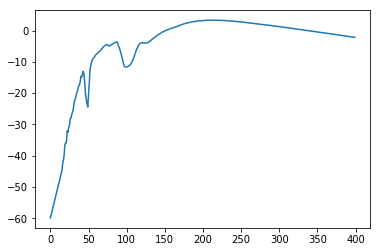

In [132]:
plt.plot(cube[400])

In [140]:
dictionary[400]

{'Tstar': 4085.4115431159084,
 'logL_star': 1.3890673639758715,
 'logM_disk': -5.33553896933579,
 'logR_disk': 2.409282268806719,
 'h_0': 0.49043691704524545,
 'logR_in': 1.7723553222218307,
 'gamma': 1.9110391974014695,
 'beta': 0.62520965655673,
 'logM_env': -2.0216208815177517,
 'logR_env': 3.1635153239287575,
 'f_cav': 0.7369179652706235,
 'ksi': 1.3976438237789122,
 'loga_max': 0.7379517049456739,
 'p': 2.997013968917735,
 'incl': 12.016776262927374,
 'filename': 'Tstar_4085.412_logLstar_1.389_logMdisk_-5.336_logRdisk_2.409_h0_0.490_logRin_1.772_gamma_1.911_beta_0.625_logMenv_-2.022_logRenv_3.164_fcav_0.737_ksi_1.398_logamax_0.738_p_2.997_incl_12.017.hdf5'}

In [145]:
xpred=[]
for i in range(15):
    xpred.append(dictionary[400][param_names[i]])
for i in range(15):
    r=(ranges[i][1]-ranges[i][0])*.1
    xpred[i]+=np.random.uniform(-r,r)

In [163]:
for i in range(15):
    print(param_names[i]+" = "+str(np.round(xpred[i],2)))

Tstar = 4224.65
logL_star = 1.69
logM_disk = -5.8
logR_disk = 2.48
h_0 = 0.45
logR_in = 2.05
gamma = 1.76
beta = 0.65
logM_env = -2.0
logR_env = 3.24
f_cav = 0.81
ksi = 1.39
loga_max = 0.92
p = 3.04
incl = 3.27


In [147]:
a=[]
for i in range(9):
    a.append(xpred)

In [148]:
preds=[]
for i in range(15):
    pred, pred_var = gps[i].predict(ws[i], a, return_var=True)
    preds.append(pred)

In [149]:
np.array(preds)[:,0]

array([32.78897686, -3.58144981, -8.34141304,  0.77385471,  0.92580192,
        1.77086683, -0.33799443,  0.49953752,  0.12311679,  0.20940413,
       -0.22855932, -0.0065357 ,  0.00544279, -0.00834988,  0.08387972])

In [167]:
for i in range(15):
    print("w"+str(i)+" = "+str(np.round(np.array(preds)[:,0][i],4)))

w0 = 32.789
w1 = -3.5814
w2 = -8.3414
w3 = 0.7739
w4 = 0.9258
w5 = 1.7709
w6 = -0.338
w7 = 0.4995
w8 = 0.1231
w9 = 0.2094
w10 = -0.2286
w11 = -0.0065
w12 = 0.0054
w13 = -0.0083
w14 = 0.0839


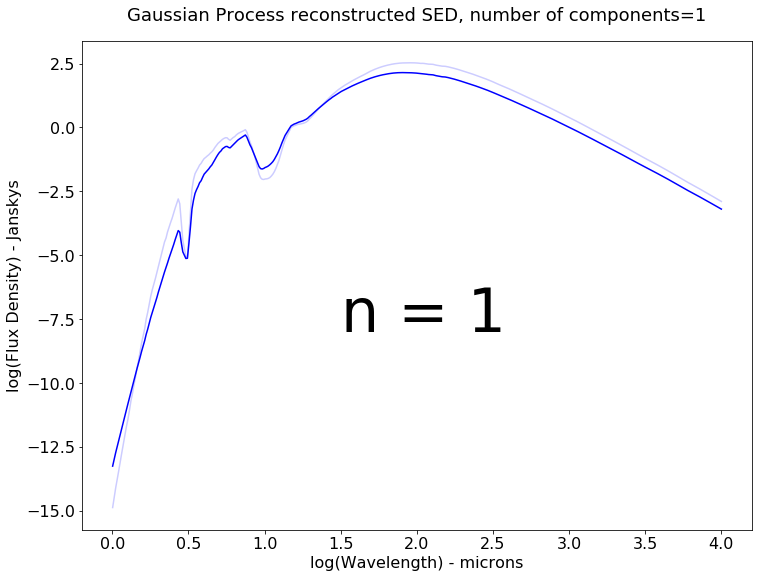

In [212]:
ncomp=15
nfeat=400
fig,ax= plt.subplots(figsize=(12,9))
coeffs=np.array(preds)[:,0]
reconst=[]
for j in range(ncomp):
    reconst.append(np.dot(coeffs[0:j+1],eigenseds[0:j+1,0:nfeat]) +\
                   pca.mean_[0:nfeat])
ax.plot(np.log10(xvals),reconst[14],c='b',alpha=0.2)
ax.tick_params(labelsize=16)
line, = ax.plot(np.log10(xvals)[0:nfeat], reconst[0], c='b')

ann_list=[]
def animate(i):
    if not len(ann_list)==0:
        ax.texts.remove(ax.texts[0])
    line.set_ydata(reconst[int(i)])
    ax.set_xlabel("log(Wavelength) - microns",fontsize=16)
    ann=ax.annotate("n = "+str(i+1),(1.5,-8),size=60)
    ann_list.append(ann)
    ax.set_ylabel("log(Flux Density) - Janskys",fontsize=16)
    ax.set_title("Gaussian Process reconstructed SED, number of components="+str(int(i)+1),fontsize=18,pad=20)
    return line,ax

#fs=np.ndarray.tolist(np.arange(0,ncomp))
#for i in range(4):
#    fs.append(ncomp-1)
fs=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,14]
anim=FuncAnimation(fig,animate,frames=fs,interval=800)
anim.save("../talk/test_gp_reconst_2.gif", dpi=72, writer="imagemagick")

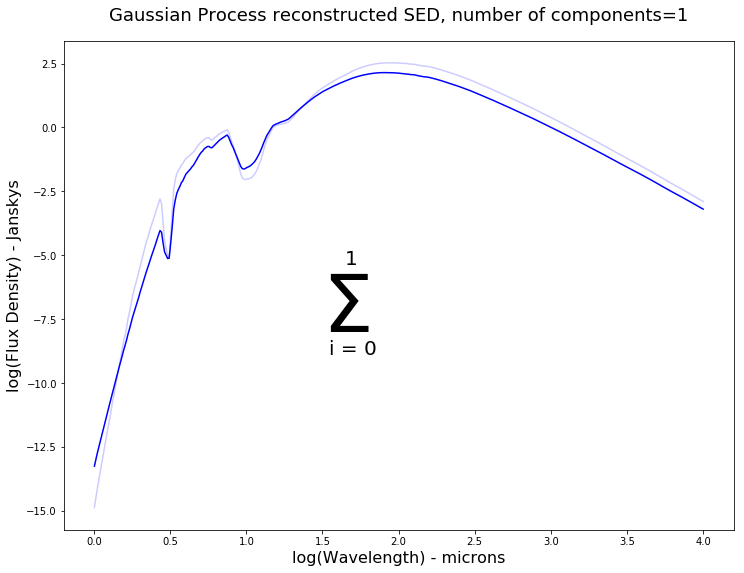

In [211]:
ncomp=15
nfeat=400
fig,ax= plt.subplots(figsize=(12,9))
coeffs=np.array(preds)[:,0]
reconst=[]
for j in range(ncomp):
    reconst.append(np.dot(coeffs[0:j+1],eigenseds[0:j+1,0:nfeat]) +\
                   pca.mean_[0:nfeat])
ax.plot(np.log10(xvals),reconst[14],c='b',alpha=0.2)
ax.annotate("$\Sigma$",(1.5,-8),size=80)
ax.annotate("i = 0",(1.54,-8.9),size=20)
line, = ax.plot(np.log10(xvals)[0:nfeat], reconst[0], c='b')

ann_list=[]
def animate(i):
    if not len(ann_list)==0:
        ax.texts.remove(ax.texts[2])
    line.set_ydata(reconst[int(i)])
    ax.set_xlabel("log(Wavelength) - microns",fontsize=16)
    ann=ax.annotate(str(i+1),(1.65,-5.35),size=20)
    ann_list.append(ann)
    ax.set_ylabel("log(Flux Density) - Janskys",fontsize=16)
    ax.set_title("Gaussian Process reconstructed SED, number of components="+str(int(i)+1),fontsize=18,pad=20)
    return line,ax

#fs=np.ndarray.tolist(np.arange(0,ncomp))
#for i in range(4):
#    fs.append(ncomp-1)
fs=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,14]
anim=FuncAnimation(fig,animate,frames=fs,interval=800)
anim.save("../talk/test_gp_reconst_3.gif", dpi=72, writer="imagemagick")